In [ ]:
from transformers import TrainingArguments, Trainer
import torch
from datasets import load_dataset
from transformers import AutoTokenizer

from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate

/home/paperspace/.pyenv/versions/3.10.6/envs/research/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-04-02 04:47:28,299] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [ ]:
yelp_dataset = load_dataset("yelp_review_full")
bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

def tokenize_function(examples):
    return bert_tokenizer(examples["text"], padding="max_length", truncation=True)

yelp_tokenized_datasets = yelp_dataset.map(tokenize_function, batched=True)
yelp_small_train_dataset = yelp_tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
yelp_small_eval_dataset = yelp_tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

set(yelp_tokenized_datasets["test"]['label'])

{0, 1, 2, 3, 4}

In [ ]:
# yelp_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=7)
yelp_training_args = TrainingArguments(output_dir="test_trainer", per_device_train_batch_size=64)


In [ ]:
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# yelp_model_path = "test_trainer/yelp_reviews"
# yelp_model_load = AutoModelForSequenceClassification.from_pretrained(yelp_model_path, num_labels=7, ignore_mismatched_sizes=True)

yelp_small_eval_dataset = yelp_tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
# print(yelp_trainer.evaluate(eval_dataset=yelp_small_eval_dataset))

In [ ]:
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_int8_training

# Load the IMDB dataset
imdb_dataset = load_dataset("imdb")

# Preprocess the IMDB dataset
def tokenize_function(examples):
    tokenized = bert_tokenizer(examples['text'], truncation=True, padding="max_length")
    tokenized['label_2'] = [label+5 for label in examples['label']]
    return tokenized

tokenized_imdb_dataset = imdb_dataset.map(tokenize_function, batched=True,  remove_columns=["text", "label"])
tokenized_imdb_dataset = tokenized_imdb_dataset.rename_column("label_2", "label")

imdb_small_train_dataset = tokenized_imdb_dataset["train"].shuffle(seed=42).select(range(10000))
imdb_small_eval_dataset = tokenized_imdb_dataset["test"].shuffle(seed=42).select(range(1000))

set(tokenized_imdb_dataset["test"]['label'])

{5, 6}

In [ ]:
# Load the previously saved model with ignore_mismatched_sizes=True to handle the size mismatch issue
yelp_model_path = "surya-narayanan/YelpRate_99500"
imdb_model = AutoModelForSequenceClassification.from_pretrained(yelp_model_path, num_labels=7, ignore_mismatched_sizes=True).to("cuda:0")


# Initialize LORA configuration
imdb_lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=1,
    lora_alpha=2,
    lora_dropout=0.1
)

# Apply LORA weights initialization using the get_peft_model function
imdb_model = get_peft_model(imdb_model, imdb_lora_config)

# Update the training arguments for LORA fine-tuning
imdb_training_args = TrainingArguments(
    output_dir="yelp2imdb_lora_rank16_lr_2e-6",
    evaluation_strategy="epoch",
    num_train_epochs=20,  # Adjust the number of epochs for LORA fine-tuning
    save_strategy="steps",
    save_steps = 100,
    save_total_limit=5,
    learning_rate=2e-6
)

# Initialize the Trainer for LORA fine-tuning
imdb_trainer = Trainer(
    model=imdb_model,
    args=imdb_training_args,
    train_dataset=imdb_small_train_dataset,
    eval_dataset=imdb_small_eval_dataset,
    compute_metrics=compute_metrics,
)

# Fine-tune the model on the IMDB dataset
# imdb_trainer.train()

# Save the final LORA fine-tuned model
# imdb_trainer.save_model("test_trainer/imdb_reviews")



In [ ]:
import os 
from peft import PeftConfig

yelp_accuracy = []
imdb_accuracy = []

directory = "ENTER DIRECTORY HERE" # Enter the directory where the checkpoints are saved

for folder in os.listdir(directory):

    if "checkpoint" in folder: 

        peft_model_id = directory + "/" + folder

        config = PeftConfig.from_pretrained(peft_model_id)
        model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path).to("cuda")
        model = PeftModel.from_pretrained(model, peft_model_id, device="cuda:0")
        model.eval()
        # tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

        # peft_model_id = "/home/paperspace/yurts-research/yurts_research_structured/train_llm/lora/test_trainer_imdb/checkpoint-125"
        # model = AutoModelForSequenceClassification.from_pretrained(peft_model_id)

        imdb_trainer.model = model
        yelp_accuracy.append(imdb_trainer.evaluate(eval_dataset=yelp_small_eval_dataset)['eval_accuracy'] * 100)
        imdb_accuracy.append(imdb_trainer.evaluate(eval_dataset=imdb_small_eval_dataset)['eval_accuracy'] * 100)



In [ ]:
print("yelp", yelp_accuracy, "imdb", imdb_accuracy)

In [ ]:
yelp_accuracy_2 = yelp_accuracy
imdb_accuracy_2 = imdb_accuracy

yelp_accuracy = yelp_accuracy[:-1]
imdb_accuracy = imdb_accuracy[:-1]

In [ ]:
len(yelp_accuracy)

In [ ]:
import matplotlib.pyplot as plt 
st_ind = 201
plt.plot(list(range(1+st_ind, st_ind+len(yelp_accuracy)+1)), yelp_accuracy, label='Yelp reviews', linewidth=3, color=(0, 0.5, 0.5))
plt.plot(list(range(1+st_ind, st_ind+len(imdb_accuracy)+1)), imdb_accuracy, label='IMDB reviews', linewidth=3, color='orange')
plt.legend()
plt.xlabel('Training step', fontsize=20)
plt.ylabel('Test accuracy', fontsize=20)
plt.xticks(list(range(1+st_ind-1,st_ind+len(yelp_accuracy)+1, 6)), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
tot_accuracy = [imdb + yelp for imdb, yelp in zip(imdb_accuracy, yelp_accuracy)]
tot_accuracy.index(max(tot_accuracy))

In [ ]:
import pickle
pickle.dump([yelp_accuracy, imdb_accuracy], open("yelp2imdb_lora_r_16_alpha_32_lr_1e-5.p", "wb"))

In [ ]:
# Evaluate the model on the Yelp dataset
print(imdb_trainer.evaluate(eval_dataset=yelp_small_eval_dataset))

# Evaluate the model on the IMDB dataset
print(imdb_trainer.evaluate(eval_dataset=imdb_small_eval_dataset))

#### PLOT weights of networks obtained via FIP and LoRA 

This is useful to examine how the networks' weights have changed while training the system on Task-2 (IMDB) from the Task-1 (Yelp) trained network. We find that LoRA trained networks are much closer in weight space than the FIP trained network. However, in functional performance - LoRA trained networks perform more poorly (i.e. succumb to Catastrophic forgetting) when compared to FIP trained networks. 

In [ ]:
frozen_weights = {}
lora_weights = {}

fro_norm_cumulative = {}

for layer_id in range(12):

    for name, parameter in imdb_trainer.model.base_model.model.bert.encoder.layer[layer_id].attention.self.named_parameters():
        #if "lora_A" in name or "lora_B" in name:
        # print(name, parameter.shape)

        if "query.weight" in name or "value.weight" in name: 
            frozen_weights[name] = parameter

        if "lora_A" in name or "lora_B" in name: 
            lora_weights[name] = parameter

    fro_norm_lora = {}
    fro_norm_lora['query'] = torch.norm(torch.matmul(lora_weights['query.lora_B.default.weight'], lora_weights['query.lora_A.default.weight']), 'fro').detach().cpu().numpy()
    fro_norm_lora['value'] = torch.norm(torch.matmul(lora_weights['value.lora_B.default.weight'], lora_weights['value.lora_A.default.weight']), 'fro').detach().cpu().numpy()

    fro_norm_frozen = {}
    for key in frozen_weights.keys():
        fro_norm_frozen[key]= torch.norm(frozen_weights[key], 'fro').detach().cpu().numpy()


    if 'query-lora' in fro_norm_cumulative.keys():
        fro_norm_cumulative['query-lora'].append(fro_norm_lora['query'])
    else:
        fro_norm_cumulative['query-lora'] = [fro_norm_lora['query']]
    
    if 'value-lora' in fro_norm_cumulative.keys():
        fro_norm_cumulative['value-lora'].append(fro_norm_lora['value'])
    else:
        fro_norm_cumulative['value-lora'] = [fro_norm_lora['value']]
    
    if 'query.weight' in fro_norm_cumulative.keys():
        fro_norm_cumulative['query.weight'].append(fro_norm_frozen['query.weight'])
    else:
        fro_norm_cumulative['query.weight'] = [fro_norm_frozen['query.weight']]

    if 'value.weight' in fro_norm_cumulative.keys():
        fro_norm_cumulative['value.weight'].append(fro_norm_frozen['value.weight'])
    else:
        fro_norm_cumulative['value.weight'] = [fro_norm_frozen['value.weight']]


In [ ]:
import matplotlib.pyplot as plt

plt.plot([lora/w_o for lora, w_o in zip(fro_norm_cumulative['query-lora'], fro_norm_cumulative['query.weight'])], label='query')
plt.plot([lora/w_o for lora, w_o in zip(fro_norm_cumulative['value-lora'], fro_norm_cumulative['value.weight'])], label='value')
plt.legend()

In [ ]:
import pickle
pickle.dump(fro_norm_cumulative, open('lora-rank-16-alpha-32.p', "wb"))


import pickle
pickle.load(fro_norm_'lora-rank-16-alpha-32')

#### FIP MODEL LOAD 


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("surya-narayanan/FIP-yelp2IMDB-checkpoint-320")


fip_trainer = Trainer(
    model=model,
    # args=imdb_training_args,
    train_dataset=imdb_small_train_dataset,
    eval_dataset=imdb_small_eval_dataset,
    # compute_metrics=compute_metrics,
)

In [ ]:
# Evaluate the model on the Yelp dataset
print(fip_trainer.evaluate(eval_dataset=yelp_small_eval_dataset))

# Evaluate the model on the IMDB dataset
print(fip_trainer.evaluate(eval_dataset=imdb_small_eval_dataset))

#### FIP evaluation

In [ ]:
yelp_model_path = "surya-narayanan/YelpRate_99500"
yelp_tuned_model = AutoModelForSequenceClassification.from_pretrained(yelp_model_path, num_labels=7, ignore_mismatched_sizes=True).to("cuda:0")


In [ ]:
delta_w = {}
w_0 = {}


for layer_id in range(12):
    for (n_yelp, p_yelp), (n_fip, p_fip) in zip(yelp_tuned_model.named_parameters(), fip_trainer.model.named_parameters()): 
        if 'layer.{}.attention.self.query.weight'.format(layer_id) in n_yelp: 
            delta_w_norm = torch.norm(p_fip-p_yelp, 'fro').detach().cpu().numpy()
            w_0_norm = torch.norm(p_yelp, 'fro').detach().cpu().numpy()
                
            if 'query.weight' in delta_w.keys():
                delta_w['query.weight'].append(delta_w_norm)
                w_0['query.weight'].append(w_0_norm)
            else: 
                delta_w['query.weight'] = [delta_w_norm]
                w_0['query.weight'] = [w_0_norm]

        if 'layer.{}.attention.self.value.weight'.format(layer_id) in n_yelp: 
            delta_w_norm = torch.norm(p_fip-p_yelp, 'fro').detach().cpu().numpy()
            w_0_norm = torch.norm(p_yelp, 'fro').detach().cpu().numpy()
                
            if 'value.weight' in delta_w.keys():
                delta_w['value.weight'].append(delta_w_norm)
                w_0['value.weight'].append(w_0_norm)
            else: 
                delta_w['value.weight'] = [delta_w_norm]
                w_0['value.weight'] = [w_0_norm]


        

In [ ]:
import matplotlib.pyplot as plt
layer_ids = list(range(1,13))
plt.plot(layer_ids, [fip_delta_w/w_o for fip_delta_w, w_o in zip(delta_w['query.weight'], w_0['query.weight'])], label='query (attn)-FIP')
plt.plot(layer_ids, [fip_delta_w/w_o for fip_delta_w, w_o in zip(delta_w['value.weight'], w_0['value.weight'])], label='value (attn)-FIP')

plt.plot(layer_ids, [lora/w_o for lora, w_o in zip(fro_norm_cumulative['query-lora'], fro_norm_cumulative['query.weight'])], label='query (attn)-Lora-rank16')
plt.plot(layer_ids, [lora/w_o for lora, w_o in zip(fro_norm_cumulative['value-lora'], fro_norm_cumulative['value.weight'])], label='value (attn)-Lora-rank16')

plt.legend()
plt.xlabel('Layer #')
plt.ylabel('$||\Delta W||_F$ / $||W_0||_F$')

In [ ]:
delta_w = []
for (n_yelp, p_yelp), (n_fip, p_fip) in zip(yelp_tuned_model.named_parameters(), fip_trainer.model.named_parameters()): 
    # print(n_yelp, p_yelp.shape)

    delta_w.append({"layer": n_yelp, "dw": p_fip-p_yelp, "rank": torch.linalg.matrix_rank(p_fip-p_yelp).item() if len(p_yelp.shape)>=2 else -1, "param_shape": p_yelp.shape})
    

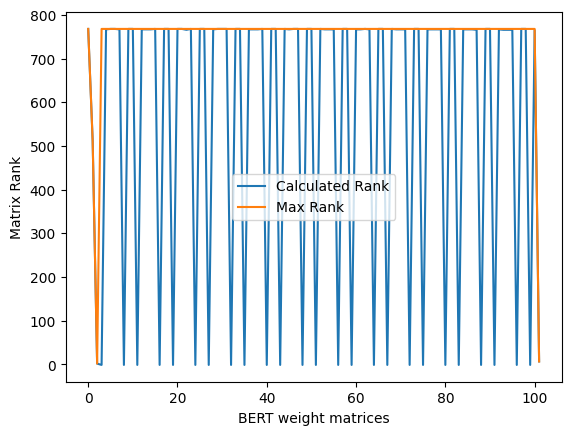

In [ ]:
import matplotlib.pyplot as plt 

plt.plot([element["rank"] for element in delta_w if ".weight" in element['layer']], label='Calculated Rank')
plt.plot([min(element["param_shape"]) for element in delta_w if ".weight" in element['layer']], label='Max Rank')
# plt.plot([min(element["param_shape"]) for element in delta_w])
plt.ylabel('Matrix Rank')
plt.xlabel('BERT weight matrices')
plt.legend()

In [ ]:
import torch
fro_norm_frozen = {}
for key in frozen_weights.keys():
    fro_norm_frozen[key]= torch.norm(frozen_weights[key], 'fro')


In [ ]:
fro_norm_lora = {}
fro_norm_lora['query'] = torch.norm(torch.matmul(lora_weights['query.lora_B.default.weight'], lora_weights['query.lora_A.default.weight']), 'fro')
fro_norm_lora['value'] = torch.norm(torch.matmul(lora_weights['value.lora_B.default.weight'], lora_weights['value.lora_A.default.weight']), 'fro')


In [ ]:
# Evaluate the model on the Yelp dataset
print(imdb_trainer.evaluate(eval_dataset=yelp_small_eval_dataset))

# Evaluate the model on the IMDB dataset
print(imdb_trainer.evaluate(eval_dataset=imdb_small_eval_dataset))

#### Train the BERT model without the LoRA adaptor

In [ ]:
# Remove LORA adapter and reset the model to its initial configuration
imdb_model_without_lora = AutoModelForSequenceClassification.from_pretrained(yelp_model_path, num_labels=2)

# Initialize the Trainer with the original model without LORA
imdb_trainer_without_lora = Trainer(
    model=imdb_model_without_lora,
    args=imdb_training_args,
    train_dataset=imdb_small_train_dataset,
    eval_dataset=imdb_small_eval_dataset,
    compute_metrics=compute_metrics,
)

# Evaluate the model on the Yelp dataset without the LORA adapter
imdb_trainer_without_lora.evaluate(eval_dataset=yelp_small_eval_dataset)


In [ ]:
# Evaluate the Yelp model on the IMDB dataset
imdb_trainer_without_lora.evaluate(eval_dataset=imdb_small_eval_dataset)

In [ ]:
# OG Bert
bert_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

bert_trainer = Trainer(
    model=bert_model,
    args=imdb_training_args, 
    compute_metrics=compute_metrics,
)

# Evaluate the out-of-the-box BERT model on the IMDB dataset
bert_imdb_results = bert_trainer.evaluate(eval_dataset=imdb_small_eval_dataset)
print("Out-of-the-box BERT results on IMDB dataset:", bert_imdb_results)

# Evaluate the out-of-the-box BERT model on the Yelp dataset
bert_yelp_results = bert_trainer.evaluate(eval_dataset=yelp_small_eval_dataset)
print("Out-of-the-box BERT results on Yelp dataset:", bert_yelp_results)



In [ ]:
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_int8_training

rt_dataset = load_dataset("rotten_tomatoes")

def tokenize_function(examples):
    return bert_tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_rt_dataset = rt_dataset.map(tokenize_function, batched=True)

rt_small_train_dataset = tokenized_rt_dataset["train"].shuffle(seed=42).select(range(1000))
rt_small_eval_dataset = tokenized_rt_dataset["test"].shuffle(seed=42).select(range(1000))


rt_model = AutoModelForSequenceClassification.from_pretrained(yelp_model_path, num_labels=2, ignore_mismatched_sizes=True)


rt_lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=4,
    lora_alpha=32,
    lora_dropout=0.1
)


rt_model = get_peft_model(rt_model, rt_lora_config)


rt_training_args = TrainingArguments(
    output_dir="test_trainer_rt",
    evaluation_strategy="epoch",
    num_train_epochs=5, 
    save_strategy="epoch",
    save_total_limit=1
)


rt_trainer = Trainer(
    model=rt_model,
    args=rt_training_args,
    train_dataset=rt_small_train_dataset,
    eval_dataset=rt_small_eval_dataset,
    compute_metrics=compute_metrics,
)


rt_trainer.train()


rt_trainer.save_model("test_trainer/rt_reviews")

In [ ]:
# Evaluate the model on the Yelp dataset
# imdb_trainer.evaluate(eval_dataset=yelp_small_eval_dataset)
rt_trainer.evaluate(eval_dataset=yelp_small_eval_dataset)

In [ ]:
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_int8_training

# Load the financial_phrasebank dataset
fpb_dataset = load_dataset("financial_phrasebank", 'sentences_allagree')

# Remove neutral labels from the dataset
def remove_neutral(examples):
    return {'sentence': examples['sentence'], 'label': examples['label']} if examples['label'] != 1 else None

fpb_dataset = fpb_dataset.filter(lambda example: example['label'] != 1)

def tokenize_function(examples):
    return bert_tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_fpb_dataset = fpb_dataset.map(tokenize_function, batched=True)

fpb_small_train_dataset = tokenized_fpb_dataset["train"].shuffle(seed=42).select(range(1000))
fpb_small_eval_dataset = tokenized_fpb_dataset["test"].shuffle(seed=42).select(range(1000))

fpb_model = AutoModelForSequenceClassification.from_pretrained(yelp_model_path, num_labels=2, ignore_mismatched_sizes=True)

fpb_lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=4,
    lora_alpha=32,
    lora_dropout=0.1
)

fpb_model = get_peft_model(fpb_model, fpb_lora_config)

fpb_training_args = TrainingArguments(
    output_dir="test_trainer_fpb",
    evaluation_strategy="epoch",
    num_train_epochs=5, 
    save_strategy="epoch",
    save_total_limit=1
)

fpb_trainer = Trainer(
    model=fpb_model,
    args=fpb_training_args,
    train_dataset=fpb_small_train_dataset,
    eval_dataset=fpb_small_eval_dataset,
    compute_metrics=compute_metrics,
)

fpb_trainer.train()

fpb_trainer.save_model("test_trainer/fpb_reviews")
